# 知識蒸餾（Knowledge Distillation）完整教學

本教學將展示如何使用知識蒸餾技術，將大型教師模型的知識轉移到小型學生模型。

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/joshhu/knowledge-distillation/blob/main/notebooks/knowledge_distillation_tutorial.ipynb)

## 📚 什麼是知識蒸餾？

知識蒸餾是一種模型壓縮技術：

- **教師模型**：大型、高效能的模型（如 ResNet18）
- **學生模型**：小型、輕量的模型
- **軟標籤**：教師模型輸出的機率分佈
- **溫度參數**：控制軟標籤的平滑程度

## 步驟 1: 環境設定

安裝必要的套件並 clone 專案

In [7]:
# 安裝依賴套件
!pip install -q torch torchvision tqdm matplotlib

# Clone 專案
!git clone https://github.com/joshhu/knowledge-distillation.git
%cd knowledge-distillation

print("✓ 環境設定完成！")

Cloning into 'knowledge-distillation'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 42 (delta 9), reused 38 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (42/42), 27.64 KiB | 3.95 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/knowledge-distillation/knowledge-distillation/knowledge-distillation/knowledge-distillation
✓ 環境設定完成！


## 步驟 2: 匯入必要的模組

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

from data import get_cifar10_dataloaders
from models import TeacherModel, StudentModel
from distillation import DistillationLoss, DistillationTrainer
from utils import set_seed, plot_training_curves, compare_models

# 檢查 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用裝置: {device}')

# 設定隨機種子
set_seed(42)

使用裝置: cuda
隨機種子已設定為: 42


## 步驟 3: 載入 CIFAR-10 資料集

In [10]:
train_loader, test_loader = get_cifar10_dataloaders(
    data_dir='./data',
    batch_size=128,
    num_workers=2
)

# Assuming CIFAR-10 with 10 classes based on the models and context
num_classes = 10
dataset_name = "CIFAR-10"

print(f"資料集: {dataset_name}")
print(f"類別數量: {num_classes}")
# The exact number of train/test samples can be obtained from the dataloaders if needed
print(f"訓練樣本: {len(train_loader.dataset)}")
print(f"測試樣本: {len(test_loader.dataset)}")

100%|██████████| 170M/170M [00:03<00:00, 49.8MB/s]


資料集: CIFAR-10
類別數量: 10
訓練樣本: 50000
測試樣本: 10000


## 步驟 4: 建立教師模型和學生模型

In [11]:
teacher_model = TeacherModel(num_classes=10).to(device)
student_model = StudentModel(num_classes=10).to(device)

print("模型建立完成！")
compare_models(teacher_model, student_model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


模型建立完成！
模型參數比較
教師模型: 11,173,962 個參數
學生模型: 667,178 個參數
壓縮比例: 16.75x
學生模型僅為教師模型的 5.97%


## 步驟 5: 訓練教師模型

注意：為了示範，這裡只訓練少量 epochs。實際應用建議訓練 20-50 epochs。

In [12]:
def train_teacher(model, train_loader, test_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    best_acc = 0
    for epoch in range(1, epochs + 1):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_acc = 100. * correct / total
        scheduler.step()
        print(f'Epoch {epoch}: 測試準確率 = {test_acc:.2f}%')

        if test_acc > best_acc:
            best_acc = test_acc

    print(f'教師模型最佳準確率: {best_acc:.2f}%')
    return model

# 訓練教師模型（設為 5 epochs 快速示範，實際建議 20+）
teacher_model = train_teacher(teacher_model, train_loader, test_loader, epochs=5)

Epoch 1: 測試準確率 = 45.37%
Epoch 2: 測試準確率 = 56.79%
Epoch 3: 測試準確率 = 66.04%
Epoch 4: 測試準確率 = 68.11%
Epoch 5: 測試準確率 = 77.96%
教師模型最佳準確率: 77.96%


## 步驟 6: 配置知識蒸餾參數

In [13]:
temperature = 3.0
alpha = 0.7
num_epochs = 10  # 示範用，實際建議 50+

distillation_loss = DistillationLoss(temperature=temperature, alpha=alpha)

optimizer = optim.SGD(
    student_model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)

scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

trainer = DistillationTrainer(
    teacher_model=teacher_model,
    student_model=student_model,
    train_loader=train_loader,
    test_loader=test_loader,
    distillation_loss=distillation_loss,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler
)

print(f"知識蒸餾配置：")
print(f"  溫度參數: {temperature}")
print(f"  Alpha: {alpha}")
print(f"  訓練輪數: {num_epochs}")

知識蒸餾配置：
  溫度參數: 3.0
  Alpha: 0.7
  訓練輪數: 10


## 步驟 7: 開始知識蒸餾訓練

In [14]:
history = trainer.train(num_epochs=num_epochs)

torch.save(student_model.state_dict(), 'student_model_distilled.pth')
print("學生模型已儲存！")

開始知識蒸餾訓練


Epoch 1: 100%|██████████| 391/391 [00:23<00:00, 16.93it/s, Loss=2.780, Acc=25.72%]



Epoch: 1/10
訓練 - 損失: 3.3771, 準確率: 25.72%
測試 - 損失: 1.6566, 準確率: 41.81%
蒸餾損失: 3.9614, 學生損失: 2.0138
🎯 新的最佳準確率: 41.81%
----------------------------------------------------------------------


Epoch 2: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s, Loss=1.488, Acc=45.68%]



Epoch: 2/10
訓練 - 損失: 2.1027, 準確率: 45.68%
測試 - 損失: 1.2611, 準確率: 54.40%
蒸餾損失: 2.3443, 學生損失: 1.5389
🎯 新的最佳準確率: 54.40%
----------------------------------------------------------------------


Epoch 3: 100%|██████████| 391/391 [00:23<00:00, 16.97it/s, Loss=1.262, Acc=57.33%]



Epoch: 3/10
訓練 - 損失: 1.4337, 準確率: 57.33%
測試 - 損失: 1.2063, 準確率: 58.48%
蒸餾損失: 1.5260, 學生損失: 1.2183
🎯 新的最佳準確率: 58.48%
----------------------------------------------------------------------


Epoch 4: 100%|██████████| 391/391 [00:23<00:00, 16.96it/s, Loss=0.972, Acc=62.71%]



Epoch: 4/10
訓練 - 損失: 1.1619, 準確率: 62.71%
測試 - 損失: 1.0997, 準確率: 63.58%
蒸餾損失: 1.2035, 學生損失: 1.0649
🎯 新的最佳準確率: 63.58%
----------------------------------------------------------------------


Epoch 5: 100%|██████████| 391/391 [00:22<00:00, 17.10it/s, Loss=0.892, Acc=66.60%]



Epoch: 5/10
訓練 - 損失: 0.9711, 準確率: 66.60%
測試 - 損失: 0.8853, 準確率: 68.13%
蒸餾損失: 0.9807, 學生損失: 0.9488
🎯 新的最佳準確率: 68.13%
----------------------------------------------------------------------


Epoch 6: 100%|██████████| 391/391 [00:22<00:00, 17.26it/s, Loss=0.932, Acc=69.21%]



Epoch: 6/10
訓練 - 損失: 0.8773, 準確率: 69.21%
測試 - 損失: 0.7651, 準確率: 72.72%
蒸餾損失: 0.8756, 學生損失: 0.8815
🎯 新的最佳準確率: 72.72%
----------------------------------------------------------------------


Epoch 7: 100%|██████████| 391/391 [00:22<00:00, 17.31it/s, Loss=0.718, Acc=71.25%]



Epoch: 7/10
訓練 - 損失: 0.7868, 準確率: 71.25%
測試 - 損失: 0.7299, 準確率: 74.46%
蒸餾損失: 0.7695, 學生損失: 0.8272
🎯 新的最佳準確率: 74.46%
----------------------------------------------------------------------


Epoch 8: 100%|██████████| 391/391 [00:22<00:00, 17.30it/s, Loss=0.786, Acc=72.59%]



Epoch: 8/10
訓練 - 損失: 0.7247, 準確率: 72.59%
測試 - 損失: 0.6994, 準確率: 75.68%
蒸餾損失: 0.6992, 學生損失: 0.7841
🎯 新的最佳準確率: 75.68%
----------------------------------------------------------------------


Epoch 9: 100%|██████████| 391/391 [00:22<00:00, 17.36it/s, Loss=0.624, Acc=73.64%]



Epoch: 9/10
訓練 - 損失: 0.6840, 準確率: 73.64%
測試 - 損失: 0.6897, 準確率: 75.96%
蒸餾損失: 0.6519, 學生損失: 0.7589
🎯 新的最佳準確率: 75.96%
----------------------------------------------------------------------


Epoch 10: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s, Loss=0.556, Acc=74.04%]



Epoch: 10/10
訓練 - 損失: 0.6613, 準確率: 74.04%
測試 - 損失: 0.6601, 準確率: 76.87%
蒸餾損失: 0.6262, 學生損失: 0.7432
🎯 新的最佳準確率: 76.87%
----------------------------------------------------------------------

訓練完成! 總耗時: 4.20 分鐘
最佳測試準確率: 76.87%
學生模型已儲存！


## 步驟 8: 視覺化訓練結果

/content/knowledge-distillation/knowledge-distillation/knowledge-distillation/knowledge-distillation/utils/helpers.py:124: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/content/knowledge-distillation/knowledge-distillation/knowledge-distillation/knowledge-distillation/utils/helpers.py:124: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/content/knowledge-distillation/knowledge-distillation/knowledge-distillation/knowledge-distillation/utils/helpers.py:124: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/content/knowledge-distillation/knowledge-distillation/knowledge-distillation/knowledge-distillation/utils/helpers.py:124: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/content/knowledge-distillation/knowledge-distillation/k

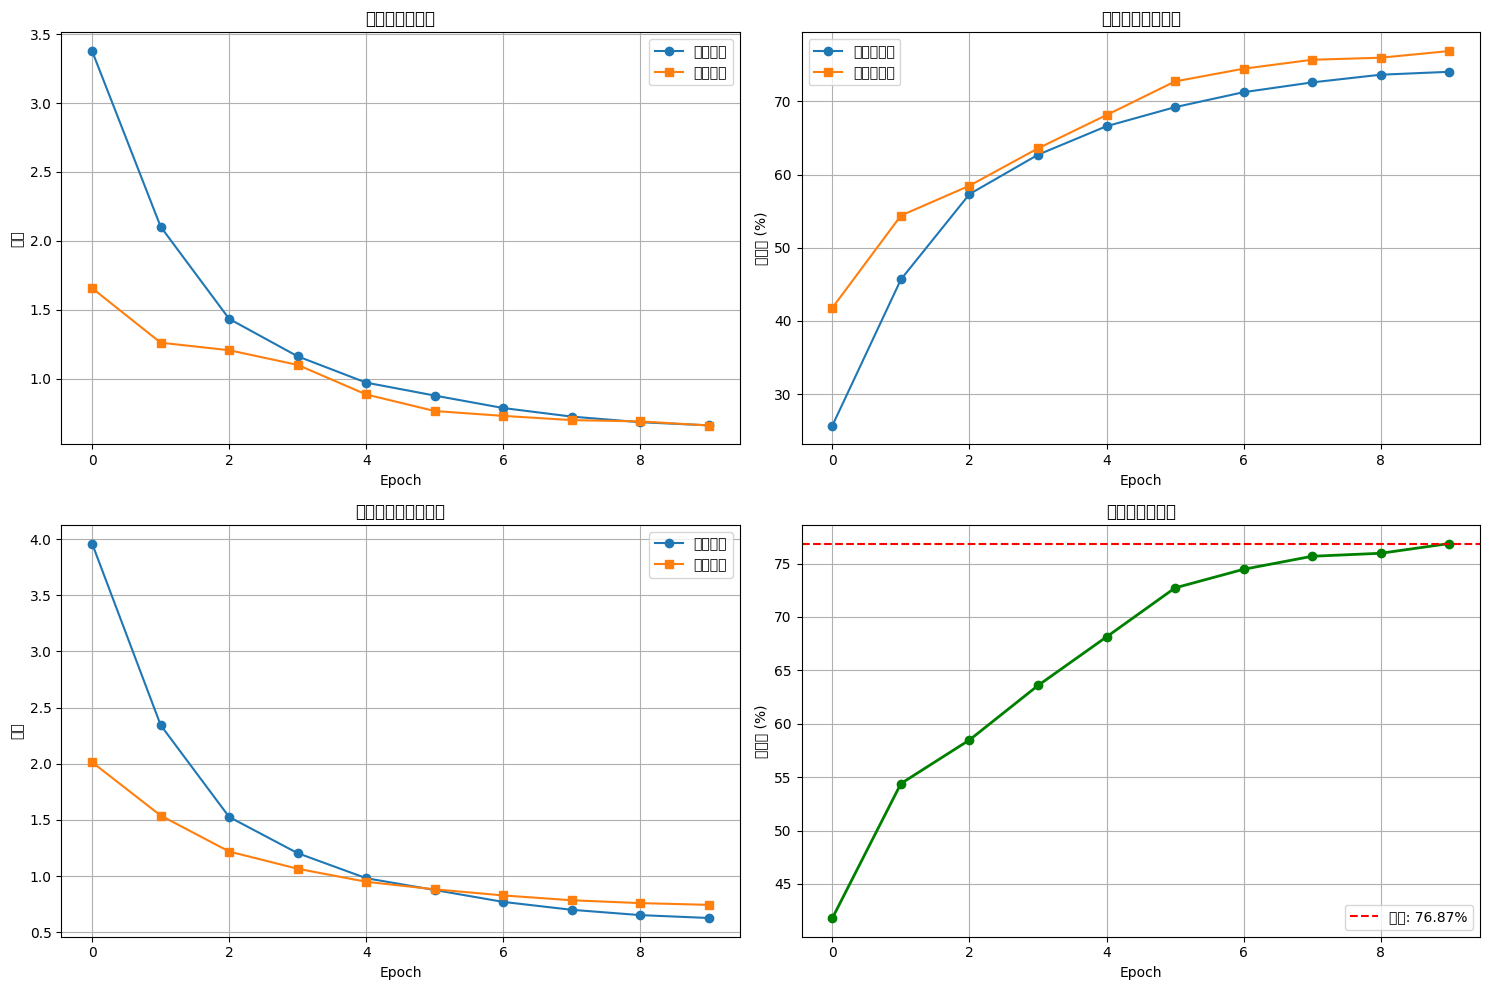

In [15]:
plot_training_curves(history)

## 步驟 9: 效能比較

In [16]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return 100. * correct / total

teacher_acc = evaluate_model(teacher_model, test_loader, device)
student_acc = evaluate_model(student_model, test_loader, device)

print("="*60)
print("最終效能比較")
print("="*60)
print(f"教師模型準確率: {teacher_acc:.2f}%")
print(f"學生模型準確率: {student_acc:.2f}%")
print(f"效能保留率: {100 * student_acc / teacher_acc:.2f}%")
print("="*60)

最終效能比較
教師模型準確率: 77.96%
學生模型準確率: 76.87%
效能保留率: 98.60%


## 🎓 總結

恭喜！你已經完成了知識蒸餾的完整流程：

1. ✅ 載入並預處理資料
2. ✅ 建立教師和學生模型
3. ✅ 訓練教師模型
4. ✅ 配置知識蒸餾
5. ✅ 訓練學生模型
6. ✅ 評估和比較效能

## 🚀 進階練習

1. 調整溫度參數（試試 1.0, 5.0, 10.0）
2. 調整 alpha 值（試試 0.5, 0.8, 0.9）
3. 增加訓練輪數到 50-100 epochs
4. 嘗試不同的模型架構

## 📚 參考資料

- [原始論文](https://arxiv.org/abs/1503.02531) - Hinton et al., 2015
- [專案 GitHub](https://github.com/joshhu/knowledge-distillation)